In [15]:
# criterion
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

boston = load_boston()
regressor = RandomForestRegressor(n_estimators = 100,random_state = 0)
cross_val_score(regressor,boston.data,boston.target,cv =10,scoring = "neg_mean_squared_error")

array([-10.72900447,  -5.36049859,  -4.74614178, -20.84946337,
       -12.23497347, -17.99274635,  -6.8952756 , -93.78884428,
       -29.80411702, -15.25776814])

In [16]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score

### 用随机森林回归填补缺失值


In [18]:
dataset = load_boston()
dataset.data.shape

(506, 13)

In [37]:
# 将完成数据的值进行赋值
x_full,y_full = dataset.data,dataset.target
n_samples = x_full.shape[0]
n_features = x_full.shape[1]

# 为完整的数据放入缺失值，假设确实50%的数据，总共确实3289个数据
rng = np.random.RandomState(0)
missing_rate = 0.5
# np.floor 向下取整，返回.0格式的浮点数
n_missing_samples = int(np.floor(n_samples * n_features * missing_rate))

# n_minssing_samples = int(np.floor(n_samples * n_features *　missing_rate))
"""
所有的数据都要随机遍布在数据集的各行各列之中，而一个缺失的数据会需要一个行索引和一个列索引
如果能够创造一个数组，包含3289个分布在0~506中间的行索引，和0~13之间的列索引，我们就可以
利用索引来为数据中任意的3289个位置赋空值

然后我们使用0，均值，和随机森林来填写这些缺失值，然后查看回归的结果如何
"""
missing_features = rng.randint(0,n_features,n_missing_samples)
missing_samples = rng.randint(0,n_samples,n_missing_samples)

x_missing = x_full.copy()
y_missing = y_full.copy()

x_missing[missing_samples,missing_features] = np.nan
x_missing = pd.DataFrame(x_missing)
x_missing.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,NaN,18.0,NaN,NaN,0.538,NaN,65.2,4.0900,1.0,296.0,NaN,NaN,4.98
1,0.02731,0.0,NaN,0.0,0.469,NaN,78.9,4.9671,2.0,NaN,NaN,396.9,9.14
2,0.02729,NaN,7.07,0.0,NaN,7.185,61.1,NaN,2.0,242.0,NaN,NaN,NaN
3,NaN,NaN,NaN,0.0,0.458,NaN,45.8,NaN,NaN,222.0,18.7,NaN,NaN
4,NaN,0.0,2.18,0.0,NaN,7.147,NaN,NaN,NaN,NaN,18.7,NaN,5.33


In [41]:
#  利用均值进行填补
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values = np.nan,strategy = 'mean')
x_missing_mean = imp_mean.fit_transform(x_missing)

# 利用0 进行填补
imp_0 = SimpleImputer(missing_values = np.nan,strategy = 'constant',fill_value = 0)
x_missing_0 = imp_0.fit_transform(x_missing)

In [57]:
# 使用随机森林进行缺失值的填补
x_missing_reg = x_missing.copy()
# 对缺失值的多少进行排序
sortindex = np.argsort(x_missing_reg.isnull().sum(axis =0)).values
for i in sortindex:
    # 构建我们的新特征矩阵和新标签
    df = x_missing_reg
    fillc = df.iloc[:,i]
    df = pd.concat([df.iloc[:,df.columns != i],pd.DataFrame(y_full)],axis =1)
    
    # 在新特征矩阵中，对含有缺失值的列，进行0的填补
    df_0 = SimpleImputer(missing_values = np.nan,
                        strategy = 'constant',fill_value = 0).fit_transform(df)
    
    # 找出我们的训练集和测试集
    y_train = fillc[fillc.notnull()]
    y_test = fillc[fillc.isnull()]
    x_train = df_0[y_train.index,:]
    x_test = df_0[y_test.index,:]
    
    # 用随机森林回归来填补缺失值
    rfc = RandomForestRegressor(n_estimators = 100)
    rfc = rfc.fit(x_train,y_train)
    ypreduct = rfc.predict(x_test)
    
    # 将填补好的特征返回到我们的原始的特征矩阵之中
    x_missing_reg.loc[x_missing_reg.iloc[:,i].isnull(),i] = ypreduct

In [59]:
x = [x_full,x_missing_mean,x_missing_0,x_missing_reg]

# 对所有的数据进行建模，取得ＭＳＥ的结果
mse = []
std = []

for x in x:
    estimator = RandomForestRegressor(random_state = 0,n_estimators = 100)
    scores = cross_val_score(estimator,x,y_full,scoring = 'neg_mean_squared_error',
                            cv =5
                            ).mean()
    mse.append(scores * -1)
    

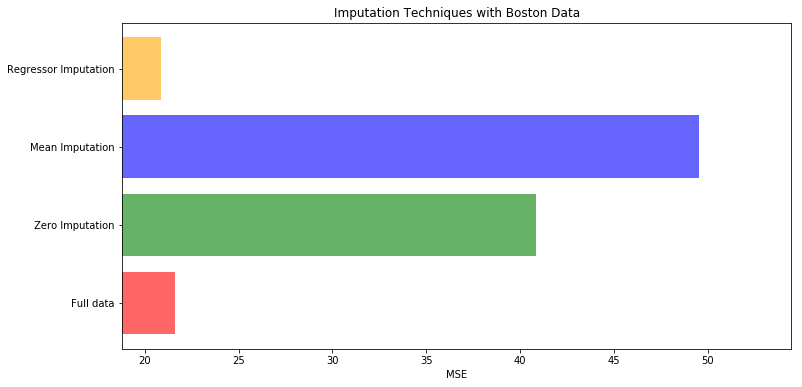

In [74]:
# 用所得的结果会出条形图
x_labels = ["Full data","Zero Imputation","Mean Imputation","Regressor Imputation"]
colors = ['r','g','b','orange']

plt.figure(figsize = (12,6))
ax = plt.subplot(111)
for i in np.arange(len(mse)):
    ax.barh(i,mse[i],color = colors[i],alpha = 0.6,align = 'center')
ax.set_title("Imputation Techniques with Boston Data")
ax.set_xlim(left= np.min(mse) * 0.9,
           right = np.max(mse) * 1.1
           )
ax.set_yticks(np.arange(len(mse)))
ax.set_xlabel("MSE")
ax.set_yticklabels(x_labels)

plt.show()